<a href="https://colab.research.google.com/github/peterij/TM10007_Diagnosing_heart_disease/blob/Sylke/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TM10007 Machine Learning**

## Import dependencies and data

In [3]:
import os
import zipfile
import pandas as pd
import numpy as np
import shutil
import subprocess
import shutil
import os
import stat
from os import path
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

## if data.csv is not present download it from github
if not os.path.isfile("ecg_data.csv"):
    ## clone repo from githun
    if not os.path.isdir("tm10007_ml"):
        !git clone https://github.com/jveenland/tm10007_ml.git
    ## extract zip file
    if not os.path.isfile("tm10007_ml/ecg/ecg_data.csv"):
        with zipfile.ZipFile('tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
            zip_ref.extractall('tm10007_ml/ecg')
    ## move data file to root folder
    shutil.move('tm10007_ml/ecg/ecg_data.csv', 'ecg_data.csv')

    ## Delete cloned repo
    for root, dirs, files in os.walk("./tm10007_ml"):  
        for dir in dirs:
            os.chmod(path.join(root, dir), stat.S_IRWXU)
        for file in files:
            os.chmod(path.join(root, file), stat.S_IRWXU)
    shutil.rmtree('./tm10007_ml')

data = pd.read_csv('ecg_data.csv', index_col=0)

## Inspect imported data and clean missing data

### Plot number of missing data per features and per patient

In [ ]:
# exclude label column
values_features = data.drop(['label'], axis=1)

# plot the distribution of missing data per feature
num_zeros_features = (values_features == 0).sum(axis=0)
plt.scatter(range(len(num_zeros_features)),num_zeros_features)
plt.title("Distribution of number of missing data per feature")
plt.ylabel('Number of missing data')
plt.xlabel('Feature')
plt.show()

# plot the distribution of missing data per patient
num_zeros_patients=(values_features == 0).sum(axis=1)
plt.scatter(range(len(num_zeros_patients)),num_zeros_patients)
plt.title("Distribution of number of missing data per patient")
plt.ylabel('Number of missing data')
plt.xlabel('Patient')
plt.show()

### Delete rows with missing data

In [ ]:
values_data = data.drop(['label'], axis=1)
mask = (values_data != 0).all(axis=1)
clean_data=data[mask]

### Plot number of missing data per features and per patient after data cleanup

In [ ]:
# exclude label column
values_clean_data = clean_data.drop(['label'], axis=1)
# plot the distribution of missing data per feature
num_zeros_features = (values_clean_data == 0).sum(axis=0)
plt.scatter(range(len(num_zeros_features)),num_zeros_features)
plt.title("Distribution of number of missing data per feature")
plt.ylabel('Number of missing data')
plt.xlabel('Feature')
plt.show()

# plot the distribution of missing data per patient
num_zeros_patients=(values_clean_data == 0).sum(axis=1)
plt.scatter(range(len(num_zeros_patients)),num_zeros_patients)
plt.title("Distribution of number of missing data per patient")
plt.ylabel('Number of missing data')
plt.xlabel('Patient')
plt.show()

## Split data into test and train data

In [2]:
x_train, x_test = model_selection.train_test_split(data, test_size=0.2)

ECG_ABNORMAL = data[data['label'] == 1]
ECG_NORMAL = data[data['label'] == 0]

x_train_abnormal, x_test_abnormal = model_selection.train_test_split(ECG_ABNORMAL, test_size=0.2)
x_train_normal, x_test_normal = model_selection.train_test_split(ECG_NORMAL,test_size = 0.2)

train_set = pd.concat([x_train_normal,x_train_abnormal])
test_set = pd.concat([x_test_normal,x_test_abnormal])


## Scale features of train and test set

In [3]:
# scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
# fit the scaler on the train set
scaler.fit(train_set)
# transform both train and test data set with the scaler
# rename the column names to the ones from 'data' again
train_set_scaled = pd.DataFrame(scaler.transform(train_set))
train_set_scaled.columns=data.columns.values
test_set_scaled = pd.DataFrame(scaler.transform(test_set))
test_set_scaled.columns=data.columns.values

## Select best features

In [44]:
# Extract the features and labels
y = train_set['label']
X = train_set.drop(['label'], axis=1)

# Select the k best features using the chi-squared test
selector = SelectKBest(chi2, k=33)
X_new = selector.fit_transform(X, y)

# Print the indices of the selected features
print(f'The k best features are {selector.get_support(indices=True)}')
scores = pd.DataFrame(selector.scores_)
# print(f'The scores for each of the k features are {scores}')

sorted_scores = scores.sort_values(scores.columns[0],ascending=False)
print(sorted_scores)
max_score = scores.max()
print(max_score)
threshold = 3500
print(threshold)
below_threshold_to_nan = sorted_scores[sorted_scores > threshold]
above_threshold = below_threshold_to_nan.dropna()
print(above_threshold)
number_above_threshold = len(above_threshold)


The k best features are [1500 3000 4506 4507 4508 4509 4510 4511 4512 4516 4517 5258 5259 5260
 5261 6004 6008 6009 6010 6011 6013 6026 6027 6750 6758 6759 6760 6761
 6777 7501 7502 7503 7510]
                 0
4509  1.242805e+04
7501  1.154899e+04
4511  1.128543e+04
5259  1.118106e+04
6010  1.102673e+04
...            ...
2794  4.030357e-08
1439  2.879124e-08
4212  2.764047e-08
328   1.322937e-08
3340  9.248157e-11

[9000 rows x 1 columns]
0    12428.054272
dtype: float64
3500
                 0
4509  12428.054272
7501  11548.985068
4511  11285.432138
5259  11181.058051
6010  11026.726385
5258  10982.392023
6009  10337.877964
5260   9139.039921
1500   7592.774990
7503   7268.205928
6008   6723.778917
6759   6403.374464
6011   6061.082563
4510   6048.073915
3000   6032.624582
6760   5981.860557
6027   5659.915483
4512   5593.532154
6761   5486.768342
4517   5047.812350
7502   4935.845652
7510   4891.074532
4507   4878.602778
6777   4636.235956
6004   4347.070820
6013   4063.540568
451

Visualize the data 

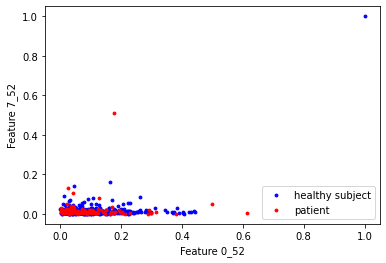

In [73]:
# Scatter plot of two features
import matplotlib.pyplot as plt

train_set_normal = train_set_scaled[train_set_scaled['label'] == 0.0]
train_set_abnormal = train_set_scaled[train_set_scaled['label'] == 1.0]

fig, ax = plt.subplots()
plt.scatter(x=train_set_normal['0_52'], y=train_set_normal['7_433'], c='blue', label='healthy subject', s=8)
plt.scatter(x=train_set_abnormal['0_52'], y=train_set_abnormal['7_433'], c='red', label='patient', s=8)
plt.legend(loc='lower right')
ax.set_xlabel('Feature 0_52')
ax.set_ylabel('Feature 7_52')
plt.show()